# Unsupervised hands-on

Today we are going to make sense of a classic dataset: [MNIST](https://en.wikipedia.org/wiki/MNIST_database) and we are going to continue using the [sklearn](https://scikit-learn.org/stable/) lib in Python.



In [1]:
# Viz
import matplotlib.pyplot as plt

# Sklearn
from sklearn import datasets, svm, metrics,cluster
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.manifold import TSNE

# Numpy
import numpy
from numpy.random import normal

Run the following cell, and read carefully the code: it contains useful variables that you can re-use in this hands-on.

In [ ]:

# We load the MNIST dataset
digits = datasets.load_digits()
image_shape = digits.images[0].shape

# Take a look at the data
_, axes = plt.subplots(nrows=1, ncols=20, figsize=(20, 3))
for ax, image, label in zip(axes, digits.images, digits.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title("Label: %i" % label)

plt.show()




In [3]:
# n_samples contains the number of images in the dataset
n_samples = len(digits.target)

# flatten the images as vectors
data = digits.images.reshape((n_samples, -1))



## Clustering k-means

Now plot the centroids of your [k-means](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.k_means.html) clustering:

In [ ]:
#TODO
k = 10
centroids,clu,variance = cluster.k_means(data, k)


# Plot the centroids
_, axes = plt.subplots(nrows=1, ncols=k, figsize=(20, 3))
for ax, image in zip(axes, centroids):
    ax.set_axis_off()
    to_plot = image.reshape(image_shape) # shape it back to an image
    ax.imshow(to_plot, cmap=plt.cm.gray_r, interpolation="nearest")

    


Vary the number of clusters and:

Compute quality indicators (labels needed):
 - AMI
 - Confusion matrix with the real labels
 
Real unsupervised measures:
 - Silhouette index
 - Intra-inter variance ratio (aka Calinski-Harabasz Index)
 
 
 You may look at the doc [here](https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation).
 
 For some of the performance metrics, make a plot to decide on what is the best number of clusters. You can use the following snippet:
`
plt.clf()
plt.plot(number_of_clust_list,performance_of_clustering_list)
plt.show()
`
 

In [ ]:
from sklearn.metrics import adjusted_mutual_info_score, confusion_matrix, silhouette_score, calinski_harabasz_score

#adjusted_mutual_info_score(digits.target, clu)
#print(confusion_matrix(digits.target, clu))
#calinski_harabasz_score(digits.target, clu)

clust_num = []
perf = []

for i in range(2,50):
    centroids,clu,variance = cluster.k_means(data, i)
    ami = calinski_harabasz_score(data, clu)
    perf.append(ami)
    
    
plt.clf()
plt.plot([i for i in range(2,50)], perf)
plt.show

## Dimensionality reduction

Plot the points in a 2-coordinate plan using [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html). Each point is a handwritten digit.
You can make a scatter plot using the following snippet:
`
plt.clf()
plt.scatter(data_to_plot[:,0],data_to_plot[:,1],c=labels)
plt.show()
`

This will color the points according to labels.

In [ ]:
pca = PCA(n_components=2)
lower_dim_data = pca.fit_transform(data)
colors = list(range(10))
plt.clf()
plt.scatter(lower_dim_data[:,0],lower_dim_data[:,1],c=digits.target) # we color by label
plt.show()



How many principal components are necessary to describe well the data?
To measure this, you can check the amount of variance captured in the low dimensional space: if the variance (inter-point square of distances) is the same as in higher dimensional space, it means that you have enough components.
    
Make a plot (x-axis = number of components, y-axis = captured variance).



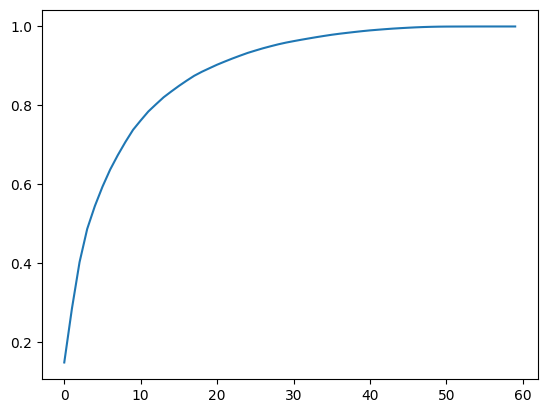

In [59]:
pca = PCA(n_components=60)
lower_dim_data = pca.fit_transform(data)


plt.clf()
plt.plot(list(range(60)),numpy.cumsum(pca.explained_variance_ratio_))
plt.show()

 

Use [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) for dimension reduction. Plot digits as a scatter plot (1 point == 1 instance of handwritten digit).

Vary the perplexity parameter between 0.001 and 100 to make a lot of sense!

Does it help?


In [ ]:
perplexities = numpy.linspace(0.001, 100, 100)
for perp in perplexities:
    print(perp)
    tsne = TSNE(n_components=2, perplexity=perp)
    lower_dim_data = tsne.fit_transform(data)
    plt.clf()
    plt.scatter(lower_dim_data[:,0],lower_dim_data[:,1],c=digits.target) # we color by label
    plt.colorbar()
    plt.show()



Comment on your results:

The more the perplexity is, the best the points fit in clusters. But after perplexity = 16, it doesn't change a lot.  

The cluster are better grouped in the tSne method than in the k-means method.

#  Hybrid solution

## Important exercise to understand one of the weird behaviors in high dimension

Clustering directly in high dimension is not always a good idea. Let's prove it!


Let's imagine that  $X_i$ is an image belonging to class $i$.
$X_i$ is centered around an average image $\mu_i$ and follows a multi variate covariance matrix $\sigma^2.I_n$.

Compute the expectation value of the distance between $X_i$ and $X_j$ with respect to $\mu_i$, $\mu_j$ and remarking that $\sum\limits_{k=1}^n Z_k^2 \sim \chi^2_n$ when $Z_k$ are independent and follow $\mathcal{N}(0,1)$.


What can you expect as the dimension grows? Can we hope to separate well classes?


The expected squared distance between two samples $X_i$ and $X_j$ is given by:  
$$
\mathbb{E}\left[\|X_i - X_j\|^2\right] = \|\mu_i - \mu_j\|^2 + 2n\sigma^2.
$$  
As the dimension $n$ increases:  
- The **noise term** $2n\sigma^2$ dominates,  
- Unless $\|\mu_i - \mu_j\|^2$ scales linearly with $n$.  

If the mean separation $\|\mu_i - \mu_j\|^2$ does not scale with $n$, the noise overwhelms the signal. Clusters become **less separable** in high dimensions, and direct clustering may fail unless class means are sufficiently distinct relative to $n$.

---

**Conclusion**:  
In high dimensions, clustering performance deteriorates due to noise dominance unless $\|\mu_i - \mu_j\|^2$ grows proportionally with $n$. Thus, classes may not be well-separated without significant mean differences.  

**Key Formula**:  
$$
\boxed{\mathbb{E}\left[\|X_i - X_j\|^2\right] = \|\mu_i - \mu_j\|^2 + 2n\sigma^2}
$$

**Notes**:  
- The noise term $2n\sigma^2$ reflects the *curse of dimensionality* in clustering.  

**Write your Latex proof here:**

Let's noise our data and see how the clustering works:

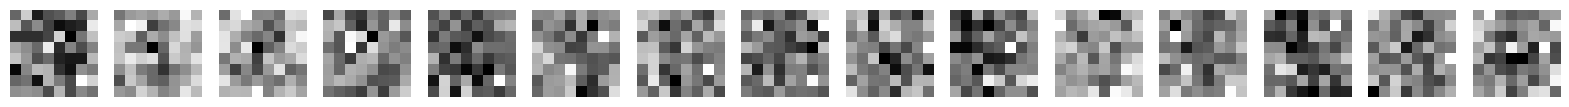

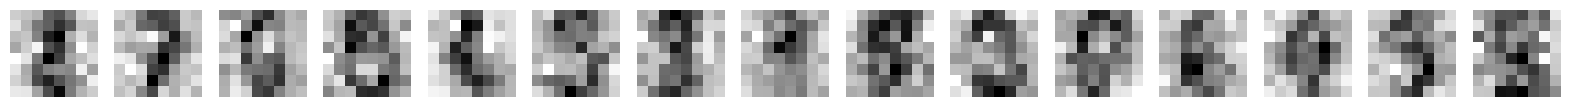

In [36]:
noisy_data = data + 13*normal(size=data.shape) 

# Plot tdata samples
_, axes = plt.subplots(nrows=1, ncols=k, figsize=(20, 3))
for ax, image in zip(axes, noisy_data):
    ax.set_axis_off()
    ax.imshow(image.reshape(image_shape), cmap=plt.cm.gray_r, interpolation="nearest")


    

k=15 # you can let 10 here, but it turns out the effect is clearer with more clusters
centroids,clu,variance =cluster.k_means(noisy_data, k)


# Plot the centroids
_, axes = plt.subplots(nrows=1, ncols=k, figsize=(20, 3))
for ax, image in zip(axes, centroids):
    ax.set_axis_off()
    to_plot = image.reshape(image_shape) # shape it back to an image
    ax.imshow(to_plot, cmap=plt.cm.gray_r, interpolation="nearest")




Can you recognize the digits in the data samples?
Answer:
Can you recognize the digits in the centroids?
Answer:

Reduce the dimension using PCA (vary the number of components between 2 and 10), and then run a k-means. Vizualise the centroids back in full dimension using the `inverse_transform` function that maps back a point from low dimension to the high dimensional space.


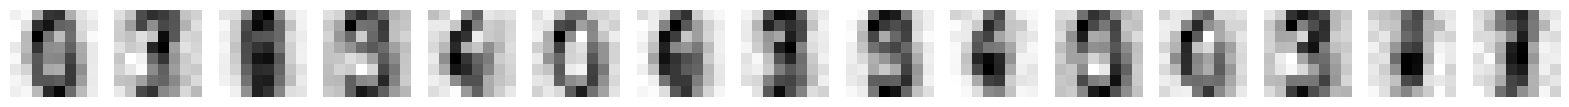

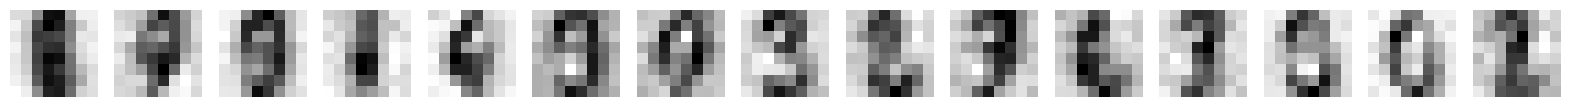

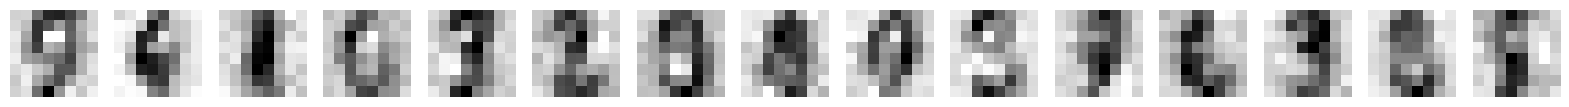

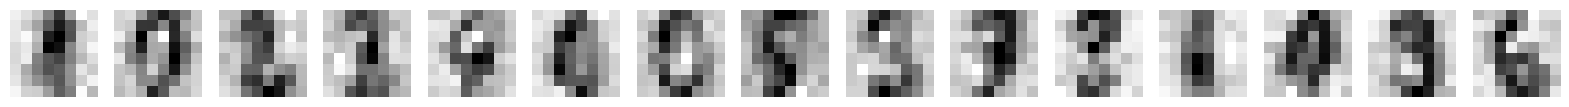

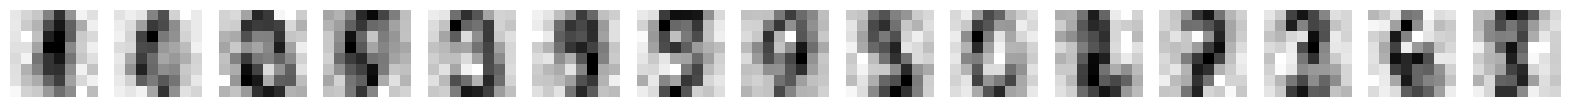

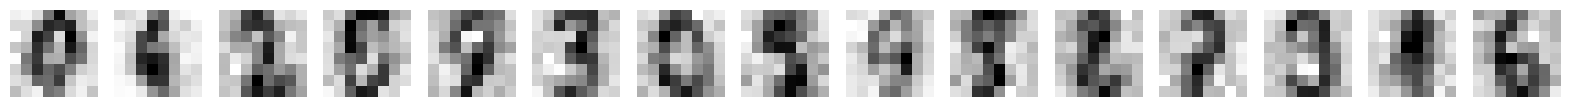

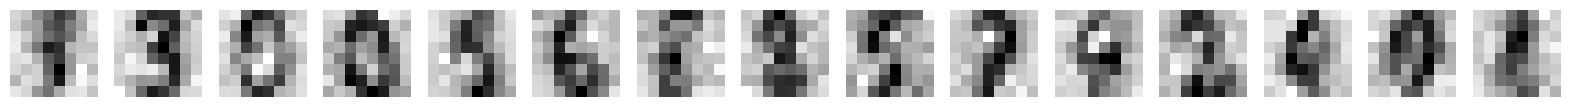

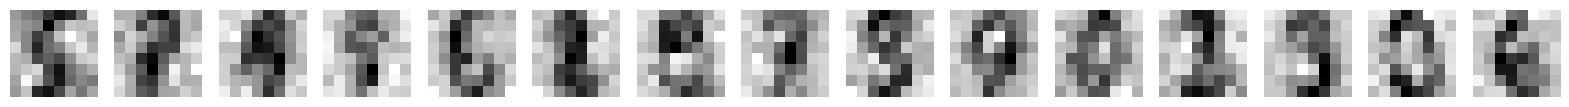

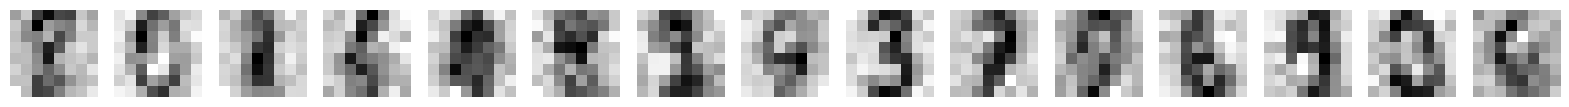

In [60]:
comp_choice = range(2,11)
k=15

for n in comp_choice:
    pca = PCA(n_components=n)
    lower_dim_data = pca.fit_transform(noisy_data)
    # k-means on lower-dim data
    centroids,clu,variance = cluster.k_means(lower_dim_data, k)
    # Plot the centroids
    _, axes = plt.subplots(nrows=1, ncols=k, figsize=(20, 3))
    for ax, centroid in zip(axes, centroids):
        ax.set_axis_off()
        ax.imshow(pca.inverse_transform(centroid).reshape(image_shape), cmap=plt.cm.gray_r, interpolation="nearest")


        



Are the centroids of better quality (can we hint the number associated with a cluster)?

it is a little better to do pca than nothing.